# 6/23
## 데이터 로드 및 전처리

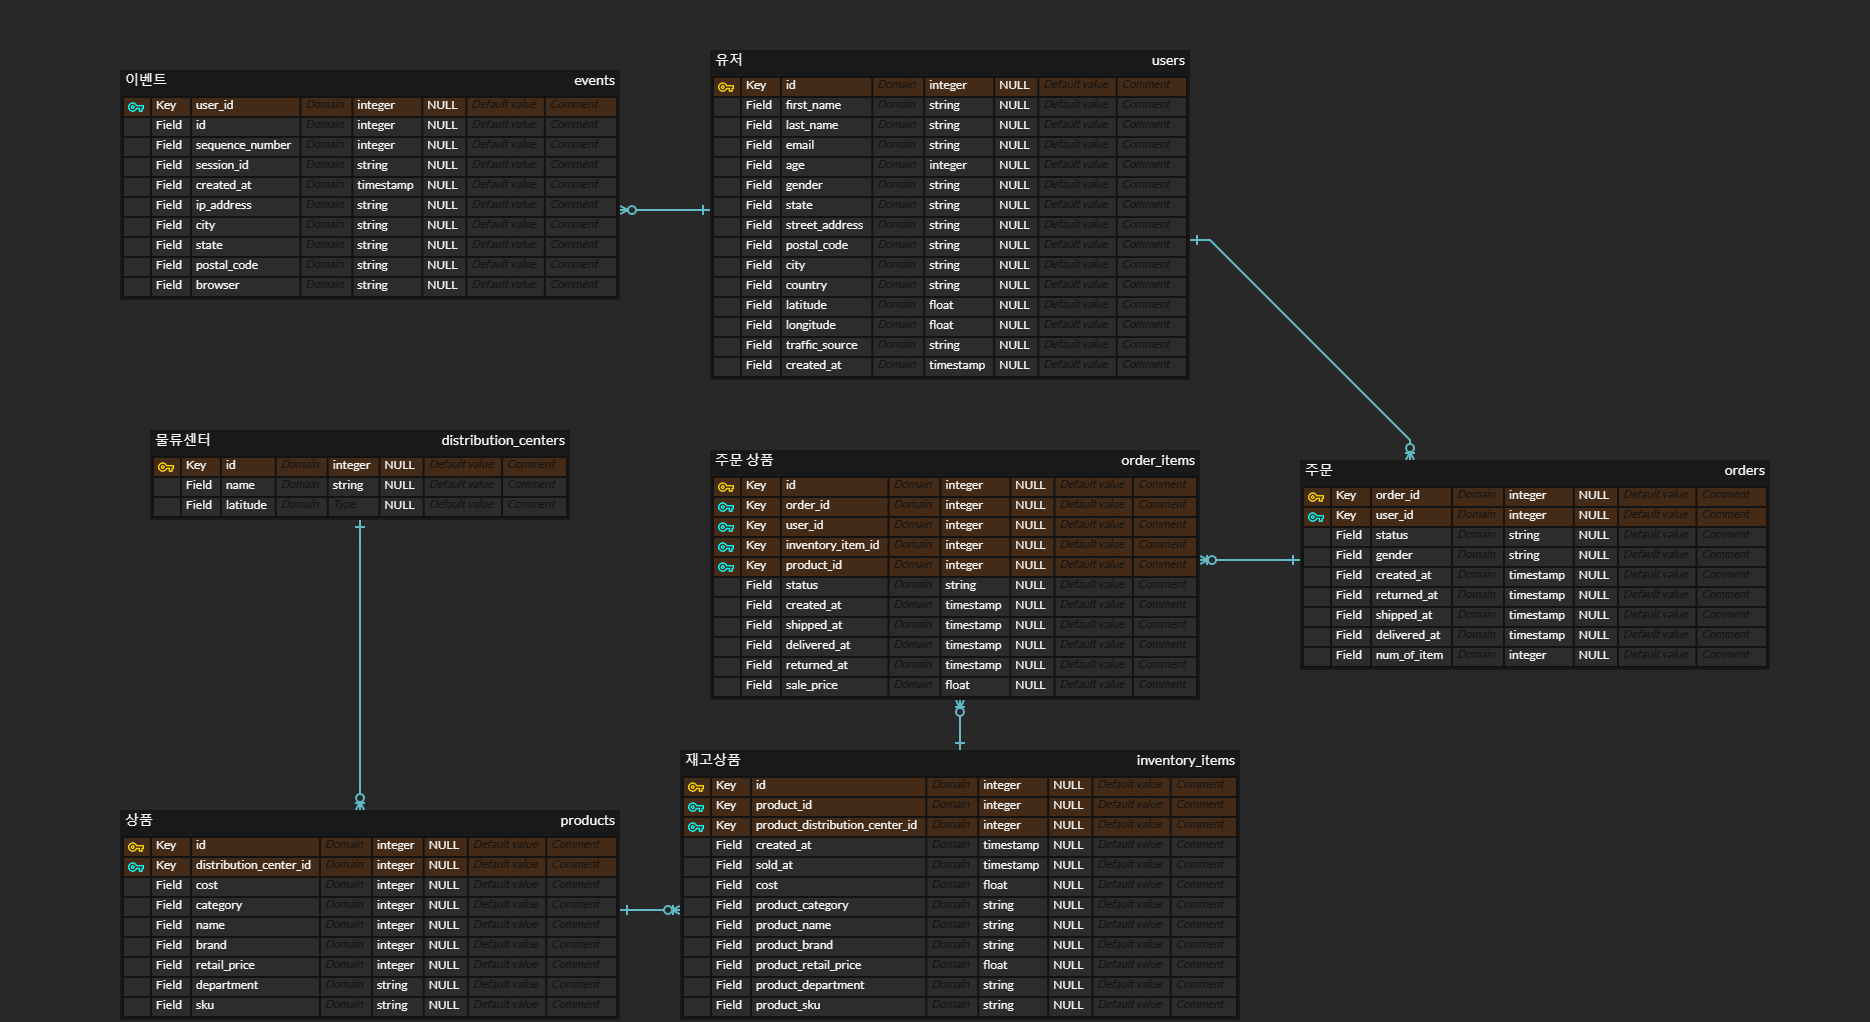

In [1]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df_order = pd.read_csv('orders.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})
df_item = pd.read_csv('order_items.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object', 'product_id' : 'object'})

In [2]:
# df_order와 df_item merge
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180907 entries, 0 to 180906
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           180907 non-null  object 
 1   user_id_x          180907 non-null  object 
 2   status_x           180907 non-null  object 
 3   gender             180907 non-null  object 
 4   created_at_x       180907 non-null  object 
 5   returned_at_x      17991 non-null   object 
 6   shipped_at_x       117220 non-null  object 
 7   delivered_at_x     63061 non-null   object 
 8   num_of_item        180907 non-null  int64  
 9   id                 180907 non-null  int64  
 10  user_id_y          180907 non-null  object 
 11  product_id         180907 non-null  object 
 12  inventory_item_id  180907 non-null  int64  
 13  status_y           180907 non-null  object 
 14  created_at_y       180907 non-null  object 
 15  shipped_at_y       117220 non-null  object 
 16  de

## 2024년 3월과 5월의 매출 성장 요인

### 3월 상품 Segment

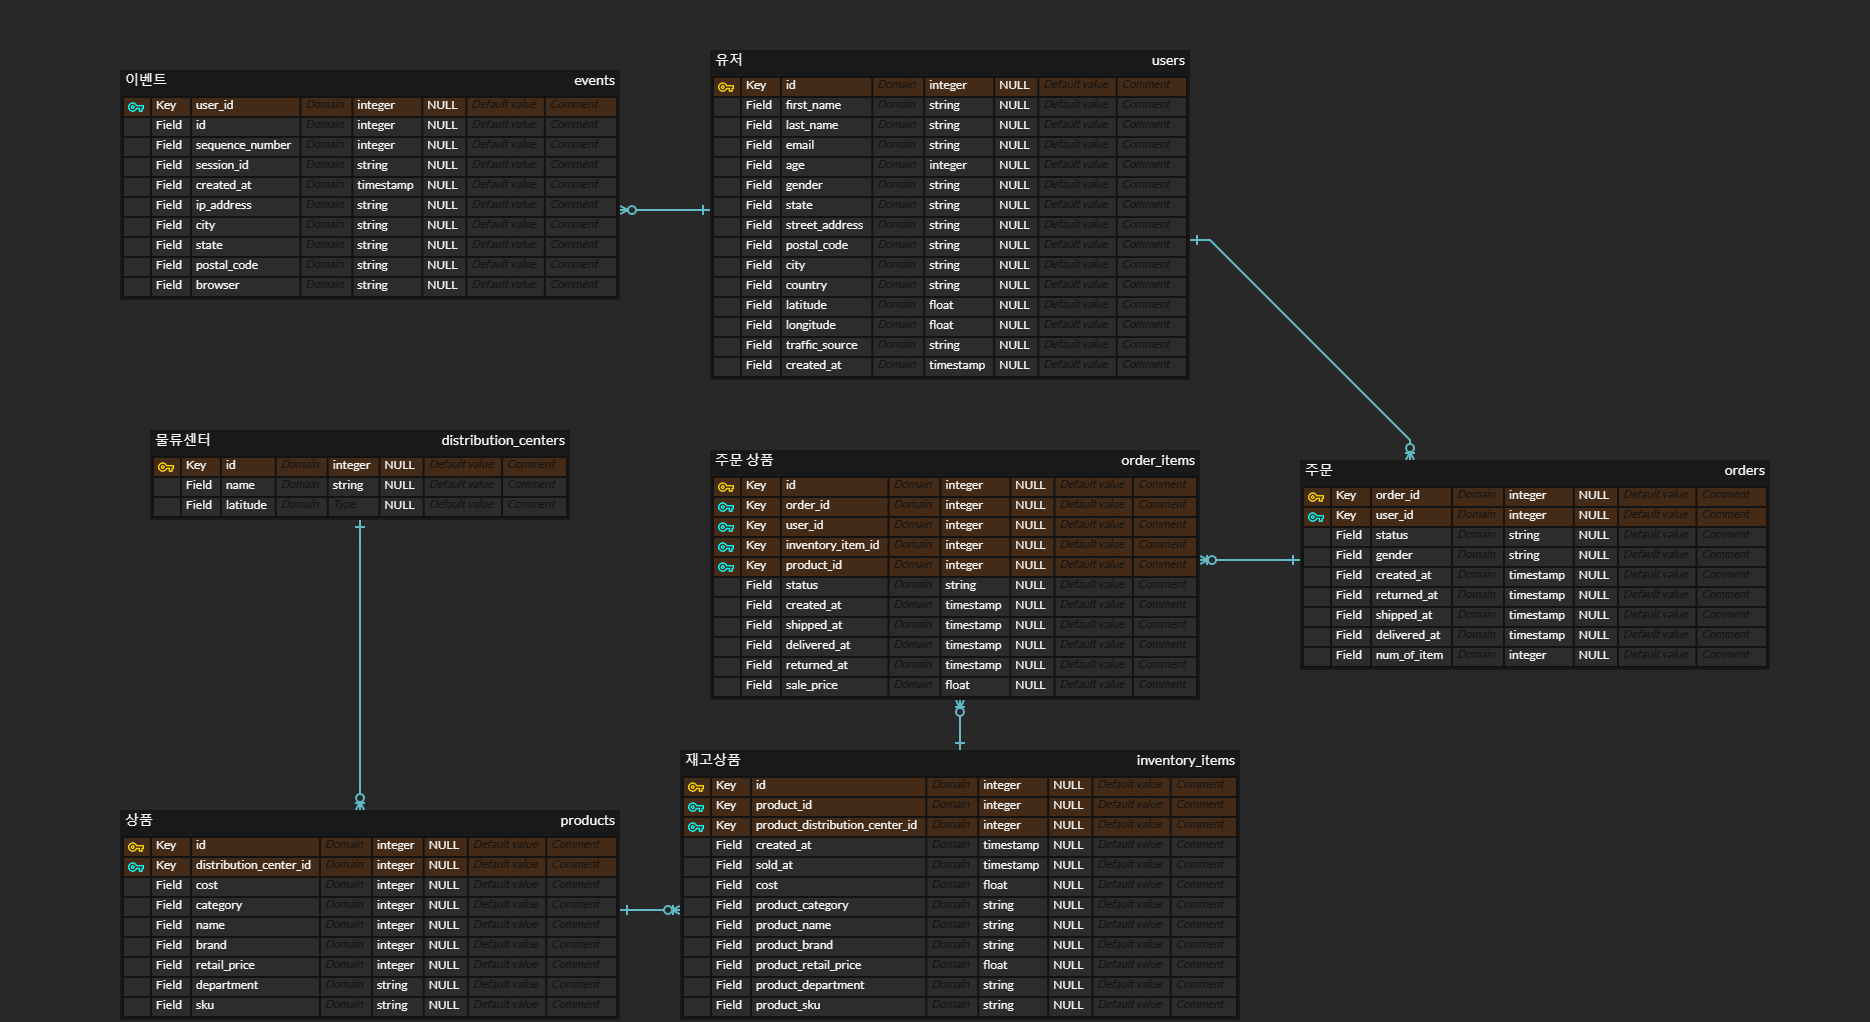

- product DB와 product_id로 JOIN이 가능하다.
- ERD 상 분석할만한 컬럼은 (cost, category, brand, retail_price, department)로 보인다.

In [4]:
df_product = pd.read_csv("products.csv", dtype={'id' : 'object'})
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  object 
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 2.0+ MB


In [5]:
df_merged = pd.merge(left = df_merged, right = df_product, left_on='product_id', right_on='id', how='left')
temp = df_merged.loc[(df_merged['created_at_x'] >= '2024-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                41253 non-null  object        
 1   user_id_x               41253 non-null  object        
 2   status_x                41253 non-null  object        
 3   gender                  41253 non-null  object        
 4   created_at_x            41253 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            30289 non-null  object        
 7   delivered_at_x          13756 non-null  object        
 8   num_of_item             41253 non-null  int64         
 9   id_x                    41253 non-null  int64         
 10  user_id_y               41253 non-null  object        
 11  product_id              41253 non-null  object        
 12  inventory_item_id       41253 non-null  int64 

C:\Users\no1\AppData\Local\Temp\ipykernel_20704\1773095757.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])


#### category 분석

In [6]:
# 3월 주문 데이터 조회 (주수 9 - 13)
temp1 = temp.loc[temp['week'].isin(range(9,14))]
temp1['week'].unique()

<IntegerArray>
[12, 11, 9, 13, 10]
Length: 5, dtype: UInt32

In [7]:
# 카테고리 개수
print(temp1['category'].nunique())
print(temp1['category'].unique())

26
['Leggings' 'Accessories' 'Skirts' 'Intimates' 'Dresses' 'Maternity'
 'Tops & Tees' 'Outerwear & Coats' 'Shorts'
 'Fashion Hoodies & Sweatshirts' 'Sweaters' 'Blazers & Jackets' 'Plus'
 'Sleep & Lounge' 'Pants & Capris' 'Active' 'Suits' 'Jeans' 'Swim'
 'Socks & Hosiery' 'Jumpsuits & Rompers' 'Clothing Sets' 'Pants'
 'Underwear' 'Suits & Sport Coats' 'Socks']


In [8]:
# 카테고리별 판매 수
temp1['category'].value_counts()
# intimates (여성 속옷)이 가장 많다.
# Jeans, Tops & Tees(티셔츠 및 기타 상의), Sleep & Lounge(잠옷 혹은 편안한 옷), 
# Fashion Hoodies & Sweatshirts (후드 & 맨투맨), Sweaters, Shorts(짧은 바지), Swim, Active(스포츠웨어),
# Accessories, Outerwear & Coats, Underwear, Pants, Socks, Dresses, Maternity(임부복), Suits & Sport Coats(남성 재킷 종류), 
# Plus, Socks & Hosiery(양말류), Pants & Capris(여성용 7부 바지), Leggings, Blazers & Jackets, Skirts, Suits, 
# Jumpsuits & Rompers (상하의 합친 옷), Clothing set

category
Intimates                        562
Jeans                            513
Tops & Tees                      502
Sleep & Lounge                   494
Fashion Hoodies & Sweatshirts    473
Sweaters                         459
Swim                             431
Shorts                           420
Active                           405
Accessories                      395
Outerwear & Coats                382
Underwear                        302
Pants                            300
Socks                            226
Maternity                        218
Dresses                          213
Suits & Sport Coats              203
Plus                             164
Socks & Hosiery                  157
Leggings                         144
Pants & Capris                   141
Blazers & Jackets                127
Skirts                            95
Suits                             45
Jumpsuits & Rompers               28
Clothing Sets                     13
Name: count, dtype: int64

In [9]:
# department와의 관계
temp1.groupby(['department','category'])['sale_price'].count().unstack().T.notnull().sum()
# 전체 26 종류의 카테고리 중에서, Men은 14종을, Women은 22종을 판매하고 있다.

department
Men      14
Women    22
dtype: int64

In [10]:
# [9, 13] 구간 내 전체 매출 중 카테고리별 매출 비율 (%)
(temp1.groupby(['category'])['sale_price'].sum() / temp1['sale_price'].sum() * 100).sort_values(ascending=False)
# 매출은 주문 수와 다르게 Outerwear & Coats, Jeans, Sweaters, ... 순이다.
# 주문 수가 가장 높았던 Intimates의 매출은 12위이다.

category
Outerwear & Coats                13.130465
Jeans                            10.870193
Sweaters                          7.617330
Suits & Sport Coats               6.066568
Fashion Hoodies & Sweatshirts     5.869906
Sleep & Lounge                    5.796737
Swim                              5.738962
Tops & Tees                       4.688732
Active                            4.407768
Shorts                            4.258155
Dresses                           4.232538
Intimates                         4.215566
Pants                             3.911258
Accessories                       3.583225
Blazers & Jackets                 2.736466
Maternity                         2.497122
Pants & Capris                    1.918253
Underwear                         1.840131
Plus                              1.329362
Suits                             1.270541
Skirts                            0.970806
Socks                             0.930930
Leggings                          0.781086
So

In [11]:
# [9, 13] 구간 내 전체 매출 중 카테고리별 매출 누적 비율 (%)
(temp1.groupby(['category'])['sale_price'].sum() / temp1['sale_price'].sum() * 100).sort_values(ascending=False).cumsum()
# 매출이 높은 순으로 누적 매출을 계산하면, Pants까지 더했을 때 전체 매출의 80%가 된다. (13종)

category
Outerwear & Coats                 13.130465
Jeans                             24.000657
Sweaters                          31.617987
Suits & Sport Coats               37.684555
Fashion Hoodies & Sweatshirts     43.554461
Sleep & Lounge                    49.351198
Swim                              55.090161
Tops & Tees                       59.778893
Active                            64.186660
Shorts                            68.444815
Dresses                           72.677353
Intimates                         76.892919
Pants                             80.804177
Accessories                       84.387402
Blazers & Jackets                 87.123868
Maternity                         89.620990
Pants & Capris                    91.539243
Underwear                         93.379374
Plus                              94.708736
Suits                             95.979277
Skirts                            96.950083
Socks                             97.881013
Leggings               

In [12]:
# 카테고리별 매출 성장률
# 주수별 매출 성장률은 CWGR로 대체. 
temp2 = temp1.groupby(['week','category'])['sale_price'].sum().unstack()
temp2['total'] = temp2.T.sum()
last_week = temp2.loc[temp2.index == 13].reset_index().drop(columns=['week'])
first_week = temp2.loc[temp2.index == 9].reset_index().drop(columns=['week'])
cwgr = ((last_week / first_week) ** (1/(13-9)) - 1).T.rename(columns={0:'cwgr'}).T
cwgr_mean = cwgr['total'][0]
cwgr_mean


0.040912867105401984

In [13]:
# 카테고리별 전체 매출 내 비중
# 주수별 매출 비중은 평균 매출 비중으로 대체.
temp2 = temp1.groupby(['week','category'])['sale_price'].sum().unstack()
temp2['total'] = temp2.T.sum()
revenue_ratio = (temp2.T / temp2['total']).T.drop(columns=['total']).mean()
revenue_ratio_mean = revenue_ratio.mean()
revenue_ratio = revenue_ratio.to_frame(name='ratio').T
revenue_ratio_mean

0.038461538461538464

In [14]:
temp3 = pd.concat([cwgr, revenue_ratio]).T
fig = px.scatter(temp3, x=temp3['cwgr'], y=temp3['ratio'], color=temp3.index)
# x축과 y축에 선 추가
fig.add_shape(type="line", x0=temp3['cwgr'].min() * 1.1, y0=revenue_ratio_mean, x1=temp3['cwgr'].max() * 1.1, y1=revenue_ratio_mean, xref='x', yref='y', line=dict(color='black', width=1))
fig.add_shape(type="line", x0=cwgr_mean, y0=-0.01, x1=cwgr_mean, y1=temp3['ratio'].max() * 1.1, xref='x', yref='y', line=dict(color='black', width=1))

# 그래프 제목 옆에 텍스트 추가
fig.add_annotation(
    x=0.5,
    y=1.1,
    xref="paper",
    yref="paper",
    text=f"전체 매출의 cwgr : {cwgr_mean.round(4)}, 평균 매출 비중 : {revenue_ratio_mean.round(4)}",
    showarrow=False,
    font=dict(
        size=14,
        color="black"
    )
)
fig.update_traces(marker=dict(size=12))
fig.update_xaxes(title_text="(평균 성장률) CWGR", showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(title_text="전체 매출 내 비중", showline=True, linewidth=1, linecolor='black', mirror=True)
# 그래프 보여주기
fig.show()

# 카테고리를 평균 cwgr과 매출 내 비중으로 나누었을 때, 네 그룹으로 나눌 수 있다.
# 1. cwgr > 전체 cwgr, ratio > 평균 매출 비중 : Jeans, Sweaters, Fashion Hoodies & Sweatshirts, Active, Shorts
# 2. cwgr < 전체 cwgr, ratio > 평균 매출 비중 : Outerwear & Coats, Suits & Sport Coats, Sleep & Lounge, Swim, Tops & Tees, Dresses, Intimates, Pants
# 3. cwgr < 전체 cwgr, ratio < 평균 매출 비중 : Blazers & Jackets, Maternity, Underwear, Socks & Hosiery, Plus, Clothing Sets
# 4. cwgr > 전체 cwgr, ratio < 평균 매출 비중 : Accessories, Pants & Capris, Socks, Skirts, Suits, Leggings, Jumpsuits & Rompers

# 각 그룹의 의미는 무엇인가?
# 1. 이 그룹의 카테고리는 매출 성장률도 좋고 전체 매출 대비 비중도 높다. 전체 매출 상승을 견인하는 카테고리다.
#    Jeans는 가장 수익성이 좋은 카테고리이다. 
# 2. 이 그룹의 카테고리는 전체 매출 대비 비중이 높으나, 매출 성장률은 상대적으로 낮아 매출 상승에 긍정적인 영향을 미치지 않았다. (1, 2 그룹 매출은 전체 매출의 80%를 차지한다.)
#    Sleep & Lounge, Pants는 역성장하여 전체 매출에 악영향을 미쳤다.
# 3. 이 그룹의 카테고리는 비중도 낮고 성장률도 낮다. 전체 매출에 거의 영향을 끼치지 않는 카테고리이다.
# 4. 이 그룹의 카테고리는 비중은 낮으나 성장률이 높다. 앞으로 해당 카테고리의 매출이 성장할 가능성이 있다.
#    Accessories는 4그룹에 속했으나 앞으로 성장하여 1그룹으로 들어갈 가능성이 있다.

In [15]:
# 어떤 그룹이 실제로 매출 상승의 주요 요인인가?
# 카테고리를 네 그룹으로 나눈 후, 전 주 대비 매출 차이를 비교해보자.
groups = [['Jeans', 'Sweaters', 'Fashion Hoodies & Sweatshirts', 'Active', 'Shorts'], 
          ['Outerwear & Coats', 'Suits & Sport Coats', 'Sleep & Lounge', 'Swim', 'Tops & Tees', 'Dresses', 'Intimates', 'Pants'], 
          ['Blazers & Jackets', 'Maternity', 'Underwear', 'Socks & Hosiery', 'Plus', 'Clothing Sets'], 
          ['Accessories', 'Pants & Capris', 'Socks', 'Skirts', 'Suits', 'Leggings', 'Jumpsuits & Rompers']]
temp2 = temp1.groupby(['week','category'])['sale_price'].sum().unstack()
temp2['total'] = temp2.T.sum()
for i, item in enumerate(groups):
    temp3 = temp2[item]
    temp3 = temp3[item].T.sum().rename(f'{i+1}_group').to_frame()
    title=set(item).difference('total')
    temp3['total'] = temp2['total']
    item.append('total')
    temp3['diff'] = temp3['total'] - temp3[f'{i+1}_group']
    temp3 = temp3 - temp3.shift(1, axis=0)
    fig = px.line(temp3)
    fig.update_xaxes(title_text="Week", showline=True, linewidth=1, linecolor='black', mirror=True, tickmode='array', tickvals=[9,10,11,12,13])
    fig.update_yaxes(title_text="매출", showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_layout(title={'text' : f"전 주 대비 매출 차이<br>{i+1} : {set(title)}", 'font': {'size': 15}})
    fig.show()
    
# 전 주 매출과 비교하여 얼마나 매출이 성장했는지를 나타내는 시각화이다.
# total과 diff가 거의 차이나지 않는다면, 해당 그룹이 total에 영향을 크게 주지 못했다는 의미이다.
# 10주와 12주, 13주에서 전체 매출 성장의 요인을 설명할 수 있다.
# 2 그룹은 13주에서 매우 큰 역성장을 기록하여 전체적인 CWGR이 낮아졌다.

In [25]:
temp1 = temp.loc[(temp['date'] >= '2024-05-01') & (temp['date'] < '2024-06-01')]
temp_index = ['Jeans', 'Sweaters', 'Fashion Hoodies & Sweatshirts', 'Active', 'Shorts']
temp1['sale_price'].loc[(temp1['category'].isin(temp_index)) & (temp1['department'] == 'Men')].sum() / temp1['sale_price'].sum()

0.20785959152631892